In [366]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import io
import os
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd

decode_dir = 'C:\\Users\\Ping\\Desktop\\Analysis_practice'
animalID = ['M7E', 'M117B']

callhist_all = np.array([]).reshape(20,10,68,0)
callhist_type_all = np.array([])

for i in range(len(animalID)):
    path = os.path.join(decode_dir, animalID[i]+'_batch','decode.mat')
    print(path)
    mat_dict = scipy.io.loadmat(path)
    #callhist[i] = mat_dict['callhist']
    callhist_all = np.append(callhist_all,mat_dict['callhist'],-1)
    callhist_type_all = np.append(callhist_type_all, mat_dict['callhist_type'])


C:\Users\Ping\Desktop\Analysis_practice\M7E_batch\decode.mat
C:\Users\Ping\Desktop\Analysis_practice\M117B_batch\decode.mat


In [367]:
callhist_all.shape

(20, 10, 68, 337)

In [368]:
callhist_type_all.shape

(337,)

In [371]:
# Loop for nsims - initially set to 1
def sim_decode(callhist, nsims=1,nunits=1):

    # Shuffle - select a random trial for each
    # Leave out and train the rest
    # Callhist dimensions are (stim, rep, time bin, unit)
   
    conf = np.empty((callhist.shape[0],callhist.shape[0]))
    conf.fill(0)    # Test actual (row), test predicted (column)

    conf2 = np.empty((callhist.shape[0],callhist.shape[0]))
    conf2.fill(0)    # Test actual (row), test predicted (column)

    for sim in range(nsims):
        rand_units = random.sample(range(callhist.shape[3]), nunits)  # without replacement
        rand_rep = random.choices(range(callhist.shape[1]), k=nunits)  # with replacement

        leftout =  np.empty((callhist.shape[0],1,callhist.shape[2],nunits))
        leftout.fill(np.nan)
        leftin = np.empty((callhist.shape[0],callhist.shape[1]-1,callhist.shape[2],nunits))
        leftin.fill(np.nan)
        leftout_y = np.empty((callhist.shape[0],nunits))
        leftout_y.fill(np.nan)

        for unit in range(nunits):
            leftout[:,:,:,unit] = np.expand_dims(callhist[:,rand_rep[unit],:,rand_units[unit]],1)
            leftin[:,:,:,unit] = np.delete(callhist[:,:,:,rand_units[unit]],rand_rep[unit],1)

        temp = np.squeeze(leftout)
        temp = np.moveaxis(temp,1,-1)   # Now time is last index, will move fastest in order C reshape (default)
        temp = temp.reshape((callhist.shape[0],temp.shape[1]*temp.shape[2]), order='C')

        temp2 = np.moveaxis(leftin,2,-1)
        temp2 = temp2.reshape((temp2.shape[0],temp2.shape[1],temp2.shape[2]*temp2.shape[3]), order='C')
        print(temp2.shape)
        X = temp2.reshape(-1,temp2.shape[-1], order='C')
        print('X:',X.shape)
        
        y = np.tile(np.expand_dims(np.array(range(temp2.shape[0])),-1),(1,temp2.shape[1]))
        y = y.reshape((y.shape[0]*y.shape[1]), order='C')
        print('\ny:',y.shape)
        print(y)
        print(X[3,:])
         
        temp3 = np.moveaxis(leftout,2,-1)
        temp3 = temp3.reshape((temp3.shape[0],temp3.shape[1],temp3.shape[2]*temp3.shape[3]), order='C')
        X_leftout = temp3.reshape(-1,temp3.shape[-1], order='C')
        print('X_leftout:',X_leftout.shape)
        
        y_leftout = np.tile(np.expand_dims(np.array(range(temp3.shape[0])),-1),(1,temp3.shape[1]))
        y_leftout = y_leftout.reshape((y_leftout.shape[0]*y_leftout.shape[1]), order='C')
        print('y_leftout:', y_leftout.shape)

        model = LinearDiscriminantAnalysis()
        model.fit(X,y)
        print(X_leftout[1,:])

        yhat = model.predict(X_leftout)
        print('y_test_actual:', y_leftout)
        print('y_test_predicted:',yhat)
        for m in range(y_leftout.shape[0]):
            conf[m,yhat[m]]=conf[m,yhat[m]]+1
        #calc percent corr
        
        # Mean templates for max correlation
        X2 = np.mean(temp2,1)
        print(X2[0,:])
        print(X_leftout[0,:])
        print(np.corrcoef(X_leftout[0,:],X2[0,:]))
        
        cor_mat = np.empty((temp3.shape[0],temp3.shape[0]))
        yhat2 = np.empty(temp3.shape[0])
        
        for test in range(temp3.shape[0]): 
            for target in range(temp3.shape[0]):
                cor_mat[test,target] = np.corrcoef(X_leftout[test,:],X2[target,:])[1,0]
            maxinds = np.where(cor_mat[test,:]==np.amax(cor_mat[test,:]))
            for k in maxinds:
                conf2[test,k] = conf2[test,k]+1/len(maxinds)
                # If tied, distribute equally
            #yhat2[test] = np.where(cor_mat[test,:]==np.amax(cor_mat[test,:]))
        print(cor_mat)
        
        #yhat2 = np.where(arr == np.amax(arr))
        #yhat2 
        print(np.corrcoef(X_leftout[0,:],X2[0,:]))
        print(np.corrcoef(X_leftout[1,:],X2[1,:]))
        print(X_leftout[0,:])
        print(X2[0,:])

    fig = plt.figure()
    ax = fig.subplots(2,1)
    ax[0].imshow(conf)   
    print('Accu:',np.trace(conf)/np.sum(conf))
    ax[1].imshow(conf2)
    print('Accu:',np.trace(conf2)/np.sum(conf2))
    #print(np.amax(conf))

(2, 2, 15)
X: (4, 15)

y: (4,)
[0 0 1 1]
[ 4.   3.2  2.   1.  -0.2  4.5  3.   2.   1.2  0.   4.   3.   2.   1.
  0. ]
X_leftout: (2, 15)
y_leftout: (2,)
[5.  4.2 3.  2.  0.8 6.5 5.  4.  3.2 2.  5.  4.  3.  2.  1. ]
y_test_actual: [0 1]
y_test_predicted: [1 1]
[0.85 2.05 3.05 4.25 5.05 0.5  1.7  2.5  3.5  5.   1.   2.   3.   4.
 5.  ]
[0.8 2.  3.  4.2 5.  2.2 3.4 4.2 5.2 6.7 1.  2.  3.  4.  5. ]
[[1.         0.86582039]
 [0.86582039 1.        ]]
[[ 0.86582039 -0.95388275]
 [-0.96965224  0.89558478]]
[[1.         0.86582039]
 [0.86582039 1.        ]]
[[1.         0.89558478]
 [0.89558478 1.        ]]
[0.8 2.  3.  4.2 5.  2.2 3.4 4.2 5.2 6.7 1.  2.  3.  4.  5. ]
[0.85 2.05 3.05 4.25 5.05 0.5  1.7  2.5  3.5  5.   1.   2.   3.   4.
 5.  ]
(2, 2, 15)
X: (4, 15)

y: (4,)
[0 0 1 1]
[ 4.5  3.   2.   1.2  0.   4.   3.2  2.   1.  -0.2  6.   5.   4.   3.
  2. ]
X_leftout: (2, 15)
y_leftout: (2,)
[5.5 4.  3.  2.2 1.  5.  4.2 3.  2.  0.8 4.  3.  2.  1.  0. ]
y_test_actual: [0 1]
y_test_predicted: [1

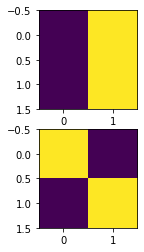

In [372]:
nsims = 10
nunits = 3   # Number of units to subsample
#nunits = callhist.shape[3]

# Test data
# 2 stims, 3 units, 3 reps
callhist_test = np.empty((2,3,5,3))
callhist_test[0,0,:,0] = [1,2,3,4,5]
callhist_test[0,0,:,1] = [1,2.2,3,4,5.5]
callhist_test[0,0,:,2] = [0.8,2,3,4.2,5]

callhist_test[1,0,:,0] = np.flipud([1,2,3,4,5])
callhist_test[1,0,:,1] = np.flipud([1,2.2,3,4,5.5])
callhist_test[1,0,:,2] = np.flipud([0.8,2,3,4.2,5])

callhist_test[0,1,:,0] = callhist_test[0,0,:,0]+1
callhist_test[0,1,:,1] = callhist_test[0,0,:,1]+1.2    # If these are exactly 1, the cor_mat becomes artificially symmetric
callhist_test[0,1,:,2] = callhist_test[0,0,:,2]+1.1

callhist_test[1,1,:,0] = callhist_test[1,0,:,0]+1
callhist_test[1,1,:,1] = callhist_test[1,0,:,1]+1
callhist_test[1,1,:,2] = callhist_test[1,0,:,2]+1

callhist_test[0,2,:,0] = callhist_test[0,0,:,0]-1
callhist_test[0,2,:,1] = callhist_test[0,0,:,1]-1
callhist_test[0,2,:,2] = callhist_test[0,0,:,2]-1

callhist_test[1,2,:,0] = callhist_test[1,0,:,0]-1
callhist_test[1,2,:,1] = callhist_test[1,0,:,1]-1
callhist_test[1,2,:,2] = callhist_test[1,0,:,2]-1

sim_decode(callhist_test,nsims,nunits)


(20, 9, 6800)
X: (180, 6800)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 6800)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  0  2  3  4 16  4  6  8  9 10 18 12 18 14 15  4  4 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.34184137]
 [0.34184137 1.        ]]
[[0.34184137 0.19305978 0.1024623  0.10928744 0.14990852 0.1969512
 

[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0 10  2  3  4 11  4  7  8  9 10  8 12 19 14 15  6 17 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.        0.3331315]
 [0.3331315 1.       ]]
[[0.3331315  0.24736786 0.13622028 0.15041424 0.17244064 0.23693883
  0.12933532 0.1627845  0.10381857 0.15876978 0.12525432 0.14836149
  0.15395358 0.14034549 0.14961461 0.14769743 0.11502661 0.18071413
  0.11564637 0.12887359]
 [0.17233535 0.28040627 0.11638882 0.1145056  0.11388061 0.16391106
  0.12598785 0.12605284 0.1275304  0.1397526  0.17497328 0.13596272
  0.18380142 0.17005105 0.13551384 0.14081964 0.09279946 0.11596606
  0.12850522 0.11751876]
 [0.10918026 0.12151492 0.34415522 0.24779191 0.18551678 0.14716191
  0.12261857 0.13194591 0.10689643 0.1593259  0.13485793 0.13206469
  0.18958263 0.14484516 0.15356169 0.13693631 0.13291145 0.14523943
  0.15245905 0.19967115]
 [0.17005314 0.09572858 0.22037728 0.

 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 6800)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  4  2  3  4  5  4  7  8  9  4 11 12 13 15 15  4 17 19 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.       0.332209]
 [0.332209 1.      ]]
[[0.332209   0.29839533 0.16648881 0.18119738 0.21645195 0.23833327
  0.17082074 0.23133515 0.15739014 0.1691077  0.1352295  0.15350677
  0.1999483  0.17226086 0.16923142 0.16767868 0.15292614 0.1890304
  0.13388948 0.16227513]
 [0.16317577 0.22799112 0.10713107 0.06529933 0.12184095 0.11931019
  0.11213357 0.10091491 0.10806561 0.13605479 0.09643609 0.08926
  0.10901083 0.10772934 0.07089977 0.10042182 0.12702711 0.12216649
  0.09519906 0.10823331]
 [0.1167149  0.14880324 0.37131223 0.26139617 0.24258282 0.24788632
  0.17334278 0.1594106  0.13678684 0.21001271 0.21558359 0.19582669
  0.27333873 0.20548988 0.23335445 0.

[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  5  4  4  4  4 10  8  8 18 11 12 13 14 14  8 10 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.29117088]
 [0.29117088 1.        ]]
[[0.29117088 0.23917529 0.17088733 0.13792903 0.19353051 0.22577614
  0.1516346  0.17623219 0.13628591 0.16636942 0.1025986  0.15363817
  0.17336537 0.12250534 0.1596309  0.1428491  0.13728554 0.17976918
  0.14327143 0.15836442]
 [0.16530227 0.19331057 0.04933365 0.05189618 0.09096365 0.09596289
  0.07431896 0.05860473 0.06252901 0.09450679 0.05672281 0.07013662
  0.08191066 0.07902172 0.05062781 0.06964023 0.07104898 0.06884832
  0.10345561 0.07587609]
 [0.0900799  0.12391284 0.37939954 0.21061073 0.21602322 0.19596466
  0.14312399 0.10801785 0.10441958 0.12230645 0.12751394 0.15150937
  0.21050203 0.12661097 0.15991246 0.13635471 0.1548652  0.11272257
  0.1415239  0.18906906]
 [0.12986747 0.09108274 0.2306242

[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 13 11 17 13 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.33756161]
 [0.33756161 1.        ]]
[[0.33756161 0.21868441 0.10082954 0.11474206 0.15543307 0.23454625
  0.16081664 0.20517906 0.12528404 0.18090727 0.15770972 0.14501553
  0.1334386  0.09687043 0.15657737 0.14593211 0.11377864 0.17211671
  0.12308495 0.14263223]
 [0.20286326 0.2410862  0.08772052 0.08896554 0.08580819 0.15296028
  0.10989615 0.14295731 0.10467034 0.13619457 0.14254529 0.10115683
  0.08364189 0.1143223  0.07888736 0.08949226 0.0914243  0.11529786
  0.0938416  0.09891458]
 [0.11124699 0.11870439 0.30718272 0.20236398 0.15706013 0.14758878
  0.14882217 0.11390141 0.13918875 0.14110761 0.13577451 0.14735345
  0.19032043 0.17883861 0.13770404 0.1244879  0.14695595 0.1264889
  0.13039942 0.16197772]
 [0.1475531  0.14214869 0.27769197

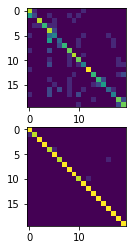

In [373]:
nsims = 10
nunits = 100

sim_decode(callhist,nsims,nunits)

(20, 9, 22916)
X: (180, 22916)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 22916)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  0 11  3  4  5  6  7  8 15  0 19 12 13 14  4  2 17  4  4]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.32187909]
 [0.32187909 1.        ]]
[[0.32187909 0.21933689 0.19124944 0.17012793 0.14310547 0.202615

(20, 9, 22916)
X: (180, 22916)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 22916)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  0  3  3  4  1  6  7  4  9 10 11 13 13 15 15  6 17 18  8]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.26073747]
 [0.26073747 1.        ]]
[[0.26073747 0.21308885 0.15913427 0.15647818 0.17455025 0.197305

(20, 9, 22916)
X: (180, 22916)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 22916)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 0  1  2  1  4  0  6  7  8  9 12 11 13 13 14 15  3 17 18 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.30515505]
 [0.30515505 1.        ]]
[[0.30515505 0.2180041  0.17721121 0.1795425  0.14620404 0.189421

(20, 9, 22916)
X: (180, 22916)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 22916)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 6  1  3 10  4  5  6  7  8  9 10 11 13 13 14 15 16 17  1 19]
[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 0. 0.]
[[1.         0.27920421]
 [0.27920421 1.        ]]
[[0.27920421 0.20932604 0.12129419 0.13652168 0.14669953 0.205830

(20, 9, 22916)
X: (180, 22916)

y: (180,)
[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10
 10 10 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 13 13 13
 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15
 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 18 19 19 19 19 19 19 19 19 19]
[0. 0. 0. ... 0. 0. 0.]
X_leftout: (20, 22916)
y_leftout: (20,)
[0. 0. 0. ... 0. 0. 0.]
y_test_actual: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
y_test_predicted: [ 6  1  3  3 15  5  6  7  8  9 10 11 17  5 14 15 16  9  9 16]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[1.         0.29649363]
 [0.29649363 1.        ]]
[[0.29649363 0.20009931 0.162576   0.1889337  0.15072966 0.209606

[[1.         0.27465963]
 [0.27465963 1.        ]]
[[1.         0.29846005]
 [0.29846005 1.        ]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
Accu: 0.595
Accu: 1.0


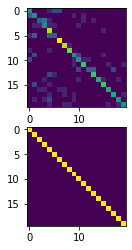

In [374]:
nsims = 10
nunits = callhist_all.shape[3]

sim_decode(callhist_all,nsims,nunits)

In [91]:
random.choices(callhist.shape[2], k=nunits)

TypeError: object of type 'int' has no len()

In [94]:
random.choices(range(callhist.shape[2]), k=nunits)

[60]

In [146]:
import numpy as np

arr1 = np.array([[3,8,15,27,15],[23,15,26,11,13]])
print(arr1)
arr1.shape
b = np.split(arr1, 5,1)
print("split array",b)
b[1]


[[ 3  8 15 27 15]
 [23 15 26 11 13]]
split array [array([[ 3],
       [23]]), array([[ 8],
       [15]]), array([[15],
       [26]]), array([[27],
       [11]]), array([[15],
       [13]])]


array([[ 8],
       [15]])

In [231]:
a = np.tile(np.expand_dims(np.array(range(3)),-1),(1,4))
a = a.reshape((a.shape[0]*a.shape[1]), order='C')
a

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])

In [326]:
arr = [1,2,3,3]
np.amax(arr)
np.where(arr==np.amax(arr))

(array([2, 3], dtype=int64),)